In [1]:
from iminuit import cost, Minuit
from numba_stats import norm, uniform
import numpy as np
from matplotlib import pyplot as plt

In [2]:
a = -1
b = 1

rng = np.random.default_rng(1)

xdata = rng.normal(0, 0.1, size=400)
xdata = np.append(xdata, rng.uniform(a, b, size=1000))

n, xe = np.histogram(xdata, bins=50)
cx = 0.5 * (xe[1:] + xe[:-1])
dx = np.diff(xe)

## Unbinned fit

In [3]:
def model_pdf(x, z, mu, sigma):
    return z * norm.pdf(x, mu, sigma) + (1-z) * uniform.pdf(x, a, b - a)

c = cost.UnbinnedNLL(xdata, model_pdf)

m = Minuit(c, z=0.3, mu=0, sigma=0.2)
m.limits["sigma"] = (0, None)
m.limits["z"] = (0, 1)
m.limits["mu"] = (-1, 1)

m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 1504                       │              Nfcn = 73               │
│ EDM = 3.7e-05 (Goal: 0.0002)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ z     │   0.275   │   0.017   │            │            │    0    │    1    │       │
│ 1 │ mu    │  -0.009   │   0.006   │            │            │   -1    │    1    │       │
│ 2 │ sigma │   0.084   │   0.006   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────┐
│       │         z        mu     sigma │
├───────┼───────────────────────────────┤
│     z │  0.000298 -3.66e-06  3.73e-05 │
│    mu │ -3.66e-06  3.79e-05 -2.31e-06 │
│ sigma │  3.73e-05 -2.31e-06  3.22e-05 │
└───────┴───────────────────────────────┘

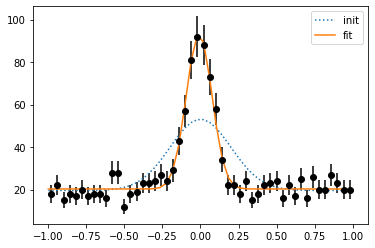

In [4]:
plt.errorbar(cx, n, n ** 0.5, fmt="ok")
xm = np.linspace(xe[0], xe[-1])
plt.plot(xm, model_pdf(xm, *[p.value for p in m.init_params]) * len(xdata) * dx[0], ls=":", label="init")
plt.plot(xm, model_pdf(xm, *m.values) * len(xdata) * dx[0], label="fit")
plt.legend();

## Extended unbinned fit

In [5]:
def scaled_model_pdf(x, nsig, mu, sigma, nbkg):    
    return nsig + nbkg, nsig * norm.pdf(x, mu, sigma) + nbkg * uniform.pdf(x, a, b - a)

c = cost.ExtendedUnbinnedNLL(xdata, scaled_model_pdf)

m = Minuit(c, nsig=300, nbkg=1500, mu=0, sigma=0.2)
m.limits["sigma"] = (0, None)
m.limits[["nsig", "nbkg"]] = (0, None)
m.limits["mu"] = (-1, 1)

m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -1.598e+04                 │              Nfcn = 110              │
│ EDM = 4.85e-05 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ nsig  │    385    │    26     │            │            │    0    │         │       │
│ 1 │ mu    │  -0.009   │   0.006   │            │            │   -1    │    1    │       │
│ 2 │ sigma │   0.084   │   0.006   │            │            │    0    │         │       │
│ 3 │ nbkg  │  1.01e3   │  0.04e3   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────┐
│       │      nsig        mu     sigma      nbkg │
├───────┼─────────────────────────────────────────┤
│  nsig │       689   -0.0051     0.052      -303 │
│    mu │   -0.0051  3.79e-05 -2.26e-06    0.0051 │
│ sigma │     0.052 -2.26e-06  3.22e-05    -0.052 │
│  nbkg │      -303    0.0051    -0.052  1.32e+03 │
└───────┴─────────────────────────────────────────┘

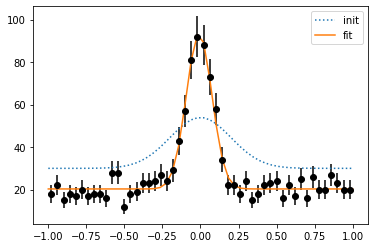

In [6]:
plt.errorbar(cx, n, n ** 0.5, fmt="ok")
xm = np.linspace(xe[0], xe[-1])
plt.plot(xm, scaled_model_pdf(xm, *[p.value for p in m.init_params])[1] * dx[0], ls=":", label="init")
plt.plot(xm, scaled_model_pdf(xm, *m.values)[1] * dx[0], label="fit")
plt.legend();

## Binned Fit

In [7]:
def model_cdf(xe, z, mu, sigma):
    return z * norm.cdf(xe, mu, sigma) + (1-z) * uniform.cdf(xe, a, b - a)

c = cost.BinnedNLL(n, xe, model_cdf)

m = Minuit(c, z=0.3, mu=0, sigma=0.2)

m.limits["sigma"] = (0, None)
m.limits["z"] = (0, 1)
m.limits["mu"] = (-1, 1)

m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 30.95                      │              Nfcn = 75               │
│ EDM = 3.14e-05 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ z     │   0.274   │   0.017   │            │            │    0    │    1    │       │
│ 1 │ mu    │  -0.008   │   0.006   │            │            │   -1    │    1    │       │
│ 2 │ sigma │   0.083   │   0.006   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────┐
│       │         z        mu     sigma │
├───────┼───────────────────────────────┤
│     z │  0.000302 -5.03e-06  4.05e-05 │
│    mu │ -5.03e-06  3.88e-05 -3.35e-06 │
│ sigma │  4.05e-05 -3.35e-06  3.48e-05 │
└───────┴───────────────────────────────┘

In [8]:
def hist(xe, w, **kwargs):
    plt.step(xe, np.append(w, w[-1]), where="post", **kwargs)

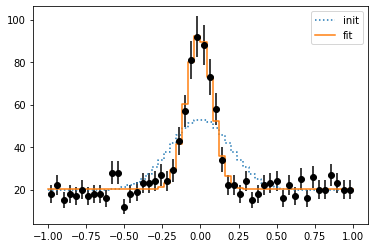

In [9]:
plt.errorbar(cx, n, n ** 0.5, fmt="ok")
hist(xe, np.diff(model_cdf(xe, *[p.value for p in m.init_params])) * len(xdata), ls=":", label="init")
hist(xe, np.diff(model_cdf(xe, *m.values)) * len(xdata), label="fit")
plt.legend();

## Extended binned Fit

In [15]:
def scaled_model_cdf(xe, nsig, mu, sigma, nbkg):
    return nsig * norm.cdf(xe, mu, sigma) + nbkg * uniform.cdf(xe, a, b - a)

c = cost.ExtendedBinnedNLL(n, xe, scaled_model_cdf)

m = Minuit(c, nsig=300, nbkg=1500, mu=0, sigma=0.2)

m.limits["sigma"] = (0, None)
m.limits[["nsig", "nbkg"]] = (0, None)
m.limits["mu"] = (-1, 1)

m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 30.33                      │              Nfcn = 119              │
│ EDM = 6.94e-05 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ nsig  │    383    │    26     │            │            │    0    │         │       │
│ 1 │ mu    │  -0.008   │   0.006   │            │            │   -1    │    1    │       │
│ 2 │ sigma │   0.083   │   0.006   │            │            │    0    │         │       │
│ 3 │ nbkg  │  1.02e3   │  0.04e3   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────┐
│       │      nsig        mu     sigma      nbkg │
├───────┼─────────────────────────────────────────┤
│  nsig │       696  -0.00703    0.0567      -313 │
│    mu │  -0.00703  3.88e-05 -3.34e-06   0.00703 │
│ sigma │    0.0567 -3.34e-06  3.48e-05   -0.0567 │
│  nbkg │      -313   0.00703   -0.0567  1.33e+03 │
└───────┴─────────────────────────────────────────┘

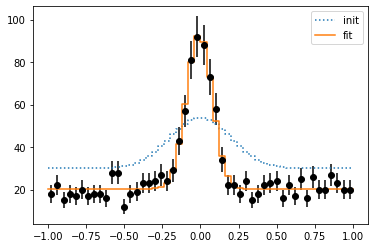

In [16]:
plt.errorbar(cx, n, n ** 0.5, fmt="ok")
hist(xe, np.diff(scaled_model_cdf(xe, *[p.value for p in m.init_params])), ls=":", label="init")
hist(xe, np.diff(scaled_model_cdf(xe, *m.values)), label="fit")
plt.legend();

## Least-squares fit (aka chi2-fit)

TODO